In [0]:
import torch
from torchvision import transforms, datasets

# Get data

In [0]:
# create a transform to normalize data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [3]:
# Download train dataset
trainset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, transform=transform, train=True)
# load data
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)

# Download test dataset
testset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=False, transform=transform)
# load data
testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=64)

0it [00:00, ?it/s]

26427392it [00:01, 14379654.37it/s]                              


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 98898.29it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 4368333.05it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 36266.41it/s]            

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


# Create a Network

In [0]:
from torch import nn, optim
import torch.nn.functional as F

Using logits at the output rather than softmax probabilities. This avoids the problem of Floating-point operation [read here](https://docs.python.org/3/tutorial/floatingpoint.html). Softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one. So we use log-probabilities

In [0]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    
    # create the network's structure
    self.input = nn.Linear(784, 256)
    self.hidden1 = nn.Linear(256, 128)
    self.hidden2 = nn.Linear(128, 64)
    self.output = nn.Linear(64, 10)
    
  # Forward Pass  
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.input(x))
    x = F.relu(self.hidden1(x))
    x = F.relu(self.hidden2(x))
    x = F.log_softmax(self.output(x), dim=1)
    
    return x

# Train

In [16]:
model = Classifier()
model

Classifier(
  (input): Linear(in_features=784, out_features=256, bias=True)
  (hidden1): Linear(in_features=256, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [0]:
# criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [18]:
# train the network
epochs = 5

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # log probabilities
    log_ps = model(images)
    
    # loss 
    loss = criterion(log_ps, labels)
    
    # backprop
    # reset gradients
    optimizer.zero_grad()
    
    # gradient calculation
    loss.backward()
    
    # update weights
    optimizer.step()
    
    # update loss
    running_loss += loss.item()
  else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.5123320291164333
Training loss: 0.3936532046209012
Training loss: 0.3557828684796148
Training loss: 0.33126578579293386
Training loss: 0.31604704980466414


# Test

In [0]:
# grab data
dataiter = iter(testloader)
images, labels = dataiter.next()

# select an image
img = images[1]
label = labels[1]

# predict
output_ps = torch.exp(model(img))

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps):
  with torch.no_grad():
    image = img.resize_(1, 28, 28).numpy().squeeze()
    ps = ps.data.numpy().squeeze()
    
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.imshow(image)

    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                              'Trouser',
                              'Pullover',
                              'Dress',
                              'Coat',
                              'Sandal',
                              'Shirt',
                              'Sneaker',
                              'Bag',
                              'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.show()

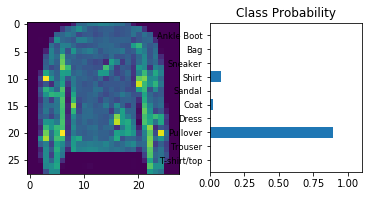

In [54]:
view_classify(img, output_ps)